# Modeling - Target: Covid 'death_rate'

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly  # used plotly graphing library for maps
import plotly.express as px
import plotly.graph_objects as go 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (RandomForestRegressor,
                              AdaBoostRegressor,
                              GradientBoostingRegressor,
                              VotingRegressor)
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

### Functions

In [4]:
def print_gs(gs, X_train, X_test, y_train, y_test):
    """
    
    """
    results = gs.cv_results_
    cv_mean = gs.cv_results_['mean_test_score'][gs.best_index_]
    cv_range = 2 * gs.cv_results_['std_test_score'][gs.best_index_]
    print('Best Score: ', gs.best_score_)
    print(f'Cross Val Score {cv_mean} +/- {cv_range}')
    print('Test Score: ', gs.score(X_test, y_test))
    print('Best Params: ', gs.best_params_)

### Import Data

In [5]:
df = pd.read_csv('../data/cleaned_merged_df.csv')

## Feature Selection
**Feature importances to use in Random Forest death rate model**

In [6]:
X = df._get_numeric_data().drop(columns=['death_rate', 'deaths', 'gini_index'])
y = df['death_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        
        #scale data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
        
        #fit random forest regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
        #get feature importances
feature_names = [f'feature {i}' for i in range(X.shape[1])]

result = permutation_importance(rf, X_train, y_train, 
                                n_repeats=10, random_state=42, 
                                n_jobs=-1)
        #create dataframe
forest_importances = pd.Series(result.importances_mean, index=feature_names)
feature_df = pd.DataFrame(columns = ['index'])
feature_df['forest_importances'] = forest_importances
feature_df.drop(columns=['index'], inplace=True)
features = list(X.T.index)
feature_df['feature'] = features
        #sort by top 20

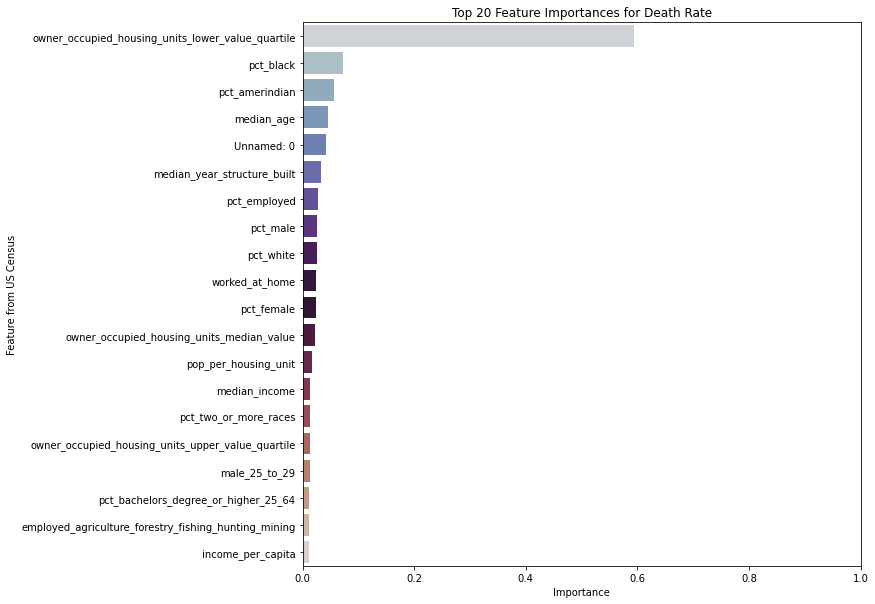

In [7]:
top_20 = feature_df.sort_values(by='forest_importances', ascending=False).head(20)
        #bar plot for sorted importances
plt.figure(figsize=(10, 10))
sns.barplot(x=top_20['forest_importances'], y=top_20['feature'],
           palette='twilight')

plt.xticks(ticks=[0, .2, .4, .6, .8, 1.0])

plt.xlabel('Importance')
plt.ylabel('Feature from US Census')
plt.title('Top 20 Feature Importances for Death Rate');

In [8]:
income_cols = [col for col in df.columns if 'income' in col or 'poverty' in col or 'group_quarters' in col]
income_cols#group quarters leaked data

['median_income',
 'income_per_capita',
 'income_less_10000',
 'income_10000_14999',
 'income_15000_19999',
 'income_20000_24999',
 'income_25000_29999',
 'income_30000_34999',
 'income_35000_39999',
 'income_40000_44999',
 'income_45000_49999',
 'income_50000_59999',
 'income_60000_74999',
 'income_75000_99999',
 'income_100000_124999',
 'income_125000_149999',
 'income_150000_199999',
 'income_200000_or_more',
 'pop_determined_poverty_status',
 'poverty',
 'percent_income_spent_on_rent',
 'group_quarters',
 'poverty_rate']

## Models

**Pipelines for Modeling**

In [60]:
pipe_lr = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestRegressor())
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostRegressor())
])

pipe_gb = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingRegressor())
])

**Filter Data & Train Test Split**

In [61]:
features = [col for col in top_20['feature']]

X = df[features]
y = df['death_rate']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=33)

**Baseline**

In [62]:
preds_base = np.ones(X_test.shape[0]) * np.mean(y_test)
baseline_rmse = np.sqrt(metrics.mean_squared_error(y_test, preds_base))
baseline_rmse

0.008582526562771298

**Interpretation:** The RMSE is 0.00858 for the baseline model which is where the predictions are the mean of the true values.

**Linear Regression**

In [64]:
gs_lr = GridSearchCV(pipe_lr, param_grid={})
gs_lr.fit(X_train, y_train)
print_gs(gs_lr, X_train, X_test, y_train, y_test)

Best Score:  0.27285402542982207
Cross Val Score 0.27285402542982207 +/- 0.038687636933353094
Test Score:  0.2131825589111438
Best Params:  {}


**Interpretation:** The test score is much lower than the cross validation score which indicates that the model is overfit. Additionally, the low scores indicate that the model is biased.

In [87]:
preds = gs_lr.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
print('Baseline RMSE: ', round(baseline_rmse, 5))
print('Model RMSE:    ', round(rmse, 5))
print(f'Improvement:    {round(baseline_rmse - rmse, 5)}' )

Baseline RMSE:  0.00858
Model RMSE:     0.00761
Improvement:    0.00097


**Random Forest Regressor**

In [65]:
params_rf = {
    'rf__max_depth': [5, 10, 15, 20]
}
gs_rf = GridSearchCV(pipe_rf, param_grid=params_rf)
gs_rf.fit(X_train, y_train)
print_gs(gs_rf, X_train, X_test, y_train, y_test)

Best Score:  0.3629611144073677
Cross Val Score 0.3629611144073677 +/- 0.04884652575238619
Test Score:  0.36933292446025423
Best Params:  {'rf__max_depth': 15}


**Interpretation:** Based on the cross validation score and test score the model is not overfit, however, the low score indicates that the model is biased.

In [86]:
preds = gs_rf.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
print('Baseline RMSE: ', round(baseline_rmse, 5))
print('Model RMSE:    ', round(rmse, 5))
print(f'Improvement:    {round(baseline_rmse - rmse, 5)}' )

Baseline RMSE:  0.00858
Model RMSE:     0.00682
Improvement:    0.00177


**Ada Boost Regressor**

In [66]:
params_ada = {
    'ada__base_estimator': [RandomForestRegressor(max_depth=3,
                                                  min_samples_leaf=10,
                                                  min_samples_split=10,
                                                  n_estimators=75)],
    'ada__learning_rate': [0.001]
}
gs_ada = GridSearchCV(pipe_ada, param_grid=params_ada, n_jobs=-1)
gs_ada.fit(X_train, y_train)
print_gs(gs_ada, X_train, X_test, y_train, y_test)

Best Score:  0.2769684410083322
Cross Val Score 0.2769684410083322 +/- 0.09676707257012346
Test Score:  0.2906687235305828
Best Params:  {'ada__base_estimator': RandomForestRegressor(max_depth=3, min_samples_leaf=10, min_samples_split=10,
                      n_estimators=75), 'ada__learning_rate': 0.001}


**Interpretation:** The ada boost regressor's cross val score is lower than the test score indicating that the model is not overfit. However, the low score indicates a large bias.

In [85]:
preds = gs_ada.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
print('Baseline RMSE: ', round(baseline_rmse, 5))
print('Model RMSE:    ', round(rmse, 5))
print(f'Improvement:    {round(baseline_rmse - rmse, 5)}' )

Baseline RMSE:  0.00858
Model RMSE:     0.00723
Improvement:    0.00135


**Gradient Boosting Regressor**

In [90]:
params_gb = {
    'gb__learning_rate': [0.001, 0.01, 0.1],
    'gb__n_estimators': [100, 1_000],
    'gb__max_depth': [5, 7, 10]
}

GradientBoostingRegressor()
gs_gb = GridSearchCV(pipe_gb, param_grid=params_gb, n_jobs=-1)
gs_gb.fit(X_train, y_train)
print_gs(gs_gb, X_train, X_test, y_train, y_test)

Best Score:  0.37401614566135316
Cross Val Score 0.37401614566135316 +/- 0.0691907519067717
Test Score:  0.38250997347449955
Best Params:  {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__n_estimators': 100}


**Interpretation:** The gradient boosting regressor is not overfit, however, the low score indicates that the model is biased.

In [84]:
preds = gs_gb.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
print('Baseline RMSE: ', round(baseline_rmse, 5))
print('Model RMSE:    ', round(rmse, 5))
print(f'Improvement:    {round(baseline_rmse - rmse, 5)}' )

Baseline RMSE:  0.00858
Model RMSE:     0.00676
Improvement:    0.00182


**Voting Regressor**

In [69]:
vote = VotingRegressor([
    ('lr', pipe_lr),
    ('rf', pipe_rf)
])

params_vote = {
    'rf__rf__max_depth': [5, 10, 15, 20],
}

gs_vote = GridSearchCV(vote,
                      param_grid=params_vote,
                      n_jobs=-1)
gs_vote.fit(X_train, y_train)
print_gs(gs_vote, X_train, X_test, y_train, y_test)

Best Score:  0.3571606844900561
Cross Val Score 0.3571606844900561 +/- 0.04865719864115468
Test Score:  0.3403232569837408
Best Params:  {'rf__rf__max_depth': 20}


**Interpretation:** The voting regressor is overfits the data. The low score indicates that the model is biased.

In [82]:
preds = gs_vote.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
print('Baseline RMSE: ', round(baseline_rmse, 5))
print('Model RMSE:    ', round(rmse, 5))
print(f'Improvement:    {round(baseline_rmse - rmse, 5)}' )

Baseline RMSE:  0.00858
Model RMSE:     0.00697
Improvement:    0.00161


### Model & Scores Table

|model|rsme|test score|cross val mean|cross val std*2|
| ---:                        | :---:   | :---: | :---: | :---: |
| Baseline                    | 0.00858 | -     | -     | -     |
| Linear Regression           | 0.00761 | 0.213 | 0.273 | 0.039 |
| Random Forest Regressor     | 0.00682 | 0.369 | 0.363 | 0.049 |
| Ada Boost Regressor         | 0.00723 | 0.291 | 0.277 | 0.097 |
| Gradient Boosting Regressor | 0.00676 | 0.383 | 0.374 | 0.069 |
| Voting Regressor            | 0.00697 | 0.340 | 0.357 | 0.049 |

### Model Selection & Results
We decided to go with the Random Forest Regressor (RFR) as our model as it was the best combination of score and range of cross validation scores. The RFR is a close second in cross validation score while also having a significantly smaller cross validation score range.

**Plotting Results**

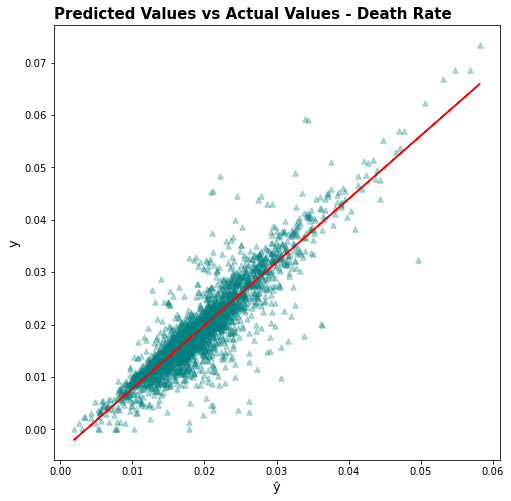

R2 Score:  0.36933292446025423


In [75]:
graph_pred  =  gs_rf.predict(X)
score       =  gs_rf.score(X_test, y_test)

plt.figure(figsize=(8,8))
plt.scatter(graph_pred, y,
           s = 30,
           color = 'teal',
           marker = '^',
           alpha=0.3)

plt.title('Predicted Values vs Actual Values - Death Rate',
          loc='left', fontweight='bold', fontsize=15)
plt.xlabel('ŷ', size=13)
plt.ylabel('y', size=13)

m, b = np.polyfit(graph_pred, y, 1)

plt.plot(graph_pred, m*graph_pred+b, color='red')

plt.show()

print("R2 Score: ", score)

**Interpretation:** The scatter plot above shows predicted covid death rates vs actual covid death rates. The graph shows that the model, at times, may be off by up to 0.03 in it's prediction, which is quite a lot as the death rates only range from 0 to 0.06. The model is not great but it shows that the selected features show at least some signal.